# MNIST Data Preprocessing
1. **Loads MNIST dataset:**
    - `(x_train, y_train), (x_test, y_test) = mnist.load_data()`
2. **Prepares training data:**
    - Reshapes first 60000 images: `images = x_train[0:60000].reshape(60000, 28*28) / 255`
    - One-hot encodes labels: `labels = np.zeros((len(labels), 10)); ...`
3. **Prepares test data:**
    - Reshapes and normalizes all test images: `test_images_all = x_test.reshape(len(x_test), 28*28) / 255`
    - One-hot encodes test labels: `test_labels_all = np.zeros((len(y_test), 10)); ...`
    - Selects first 6000 test images and labels: `test_images, test_labels = test_images_all[0:6000], test_labels_all[0:6000]`



In [22]:
import sys, numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
# Preparing the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[0:60000].reshape(60000,28*28) / 255, y_train[0:60000])
one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images_all = x_test.reshape(len(x_test), 28*28) / 255
test_labels_all = np.zeros((len(y_test), 10))
for i, l in enumerate(y_test):
    test_labels_all[i][l] = 1
test_images = test_images_all[0:6000]
test_labels = test_labels_all[0:6000]

In [23]:
print(f'The shape of Training images: {images.shape}')
print(f'The shape of Training labels: {labels.shape}')
print(f'The shape of test images: {test_images.shape}')
print(f'The shape of test labels: {test_labels.shape}')

The shape of Training images: (60000, 784)
The shape of Training labels: (60000, 10)
The shape of test images: (6000, 784)
The shape of test labels: (6000, 10)


# Model Initialization

- **Layer Definitions:**
    - `HIDDEN_LAYER_SIZE = 100`: Number of neurons in the hidden layer.
    - `OUTPUT_LAYER_SIZE = 10`: Number of neurons in the output layer (matching 10 digits in MNIST).
    - `INPUT_LAYER_SIZE = images.shape[1]`: Number of input features (784 pixels for MNIST images).
- **Model Weights and Biases:**
    - `W1`: Weights connecting input layer to hidden layer (784x100 matrix).
    - `b1`: Biases for hidden layer neurons (1x100 vector).
    - `W2`: Weights connecting hidden layer to output layer (100x10 matrix).
    - `b2`: Biases for output layer neurons (1x10 vector).
- **Random Initialization:**

    Xavier initialization aims to prevent vanishing or exploding gradients in neural networks by:

    1. Scaling weights: It calculates a gain based on the layer's input and output size, influencing the range of randomly generated weights.
    This helps avoid extreme values that could disrupt gradient flow.

    2. Balancing signal flow: By adjusting the weight range based on layer size, Xavier initialization aims to maintain a good balance between signal strength across different layers,
    preventing vanishing or exploding gradients during training.

**Purpose:**

- Creates a basic neural network model with one hidden layer, ready for training on the prepared MNIST data.
```**


In [24]:
def Xavier_init(input, output):
    gain = np.sqrt(2.0 / (input + output))
    return np.random.uniform(-gain, gain, size=(input, output))

In [25]:
HIDDEN_LAYER_SIZE = 100
OUTPUT_LAYER_SIZE = 10
INPUT_LAYER_SIZE = images.shape[1] # 784
epsilon = 1e-8
model = {
    'W1': Xavier_init(INPUT_LAYER_SIZE,HIDDEN_LAYER_SIZE), # 784 x HIDDEN_LAYER_SIZE
    'W2': Xavier_init(HIDDEN_LAYER_SIZE, OUTPUT_LAYER_SIZE), # HIDDEN_LAYER_SIZE x OUTPUT_LAYER_SIZE
    'Gamma1': np.ones((HIDDEN_LAYER_SIZE, )),
    'Beta1': np.zeros((HIDDEN_LAYER_SIZE, ))
}


# Activation Functions

**Defined Functions:**

- **`sigmoid(x)`:**
    - S-shaped curve that maps input values between 0 and 1.
    - Commonly used in output layers for binary classification.
    - `np.clip(x, -50, 50)` prevents numerical overflow.
- **`sigmoid_derivative(x)`:**
    - Calculates the derivative of the sigmoid function, used for backpropagation.
- **`relu(x)`:**
    - Rectified Linear Unit, outputs 0 for negative inputs and the input value itself for positive inputs.
    - Promotes sparsity and helps prevent vanishing gradients.
- **`relu2deriv(output)`:**
    - Derivative of ReLU, used for backpropagation.

**Purpose:**

- These functions introduce non-linearity into neural networks, enabling them to learn complex patterns and decision boundaries.
- They are essential for the training process, as they determine how neurons transform their inputs into outputs and how errors are propagated back to adjust weights and biases.
```**


In [26]:
def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return (x > 0) * x
def relu2deriv(output):
    return output > 0

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def softmax2deriv(output_layer):
    jacobian_matrix = output_layer * (1 - output_layer)
    return jacobian_matrix




 **exponentially weighted averages (EWMAs) (The way how we looking at the last grdients):**

**What they are:**

- A way to calculate an average that gives more weight to recent data points, making it especially useful for tracking trends in time-series data.
- It achieves this by assigning decreasing weights to older data points in an exponential manner—like an echo that gradually fades away.

**How they work:**

1. **Choose a weighting parameter (β):** This value, between 0 and 1, determines how quickly the weights decline. Higher β values place more emphasis on recent data.
2. **Initialize the EWMA:** Start with the first data point as the initial EWMA value.
3. **Calculate the EWMA for each subsequent data point:**
   - Use the formula: `EWMA_t = β * EWMA_(t-1) + (1 - β) * x_t`
      - `EWMA_t` is the EWMA at time t
      - `EWMA_(t-1)` is the previous EWMA value
      - `x_t` is the current data point
4. **Update iteratively:** The EWMA value is updated with each new data point, creating a smooth, responsive average that reflects the most recent trends.

In [27]:
# Data to be smoothed (e.g., a stock's price over time)
data = np.array([10, 12, 15, 13, 18, 16, 20, 14, 10, 16])

# Parameter controlling the weight given to recent data (between 0 and 1)
beta = 0.9

# Initialize the first value of the EWMA
t_1 = data[0] # 10

# Calculate the EWMA for each subsequent data point
for value in data[1:]:
    print(f'New input from the data is: {value} and the EMWA new value is {t_1}')
    t_1 = beta * t_1 + (1 - beta) * value 

print("Exponentially Weighted Average:", t_1)

New input from the data is: 12 and the EMWA new value is 10
New input from the data is: 15 and the EMWA new value is 10.2
New input from the data is: 13 and the EMWA new value is 10.68
New input from the data is: 18 and the EMWA new value is 10.911999999999999
New input from the data is: 16 and the EMWA new value is 11.6208
New input from the data is: 20 and the EMWA new value is 12.05872
New input from the data is: 14 and the EMWA new value is 12.852848
New input from the data is: 10 and the EMWA new value is 12.9675632
New input from the data is: 16 and the EMWA new value is 12.67080688
Exponentially Weighted Average: 13.003726192


 **Here's a theoretical and technical explanation of the Adam optimizer:**

**Theoretical Overview:**

- **Combines momentum and adaptive learning rates:** Adam incorporates the advantages of both approaches for efficient optimization.
- **Momentum:** Accelerates learning in relevant directions, dampens oscillations, and helps escape local minima.
- **Adaptive Learning Rates:** Adjusts learning rates for each parameter based on historical gradients, leading to faster convergence and better generalization.
- **Bias Correction:** Addresses initial bias in momentum and squared gradient estimates, allowing for faster progress in early stages and improving stability.


   -  **Bias Correction:**
      1. **Initial Bias:**
      - Adam uses exponential moving averages to track momentum and squared gradients. These averages start close to zero and gradually build up over time.
      - If not corrected, this initial bias towards zero can cause smaller updates in the early iterations, potentially slowing down convergence.

      2. **Bias Correction:**
      - To address this, Adam applies a bias correction factor to both the momentum and squared gradient estimates.
      - The correction factor is 1 / (1 - beta^t), where beta is the decay rate (usually 0.9 or 0.999) and t is the current iteration.
      - This factor effectively scales up the estimates, compensating for the initial bias towards zero and allowing for more meaningful updates even in the early stages <span style="color: orange;">(Explained with code in Draft cells sector)</span>.

      3. **Impact on Updates:**
      - The corrected momentum and squared gradient estimates are then used to update the weights:
         - Weight update = learning_rate * corrected_momentum / sqrt(corrected_squared_gradient + epsilon)
      - This ensures that updates are appropriately scaled even when the averages are small, leading to faster convergence and smoother training.

      4. **Key Points:**
      - Bias correction doesn't directly force weights to be larger. It adjusts the momentum and squared gradient estimates to address their initial bias, allowing for more effective updates.
      - It's crucial for faster convergence and smoother training, especially in the early stages.
      - It's a key component of the Adam optimizer, contributing to its overall efficiency and effectiveness.


**Technical Implementation:**

1. **Initialization:**
   - Set momentum terms (mt) and squared gradients (vt) to zero for all parameters.
   - Choose hyperparameters: beta1 (momentum decay), beta2 (squared gradient decay), learning rate (α), and epsilon (small constant for numerical stability).

2. **Iteration:**
   - For each parameter θ at iteration t:
     - Calculate gradient (gt).
     - Update momentum: mt = beta1 * mt-1 + (1 - beta1) * gt.
     - Update squared gradient: vt = beta2 * vt-1 + (1 - beta2) * gt^2.
     - Bias correction: mt_hat = mt / (1 - beta1^t), vt_hat = vt / (1 - beta2^t).
     - Update parameter: θt = θt-1 - α * mt_hat / (sqrt(vt_hat) + ε).

3. **Repeat:**
   - Continue iterations until convergence or specified number of epochs.

**Key Hyperparameters:**

- **beta1:** Controls momentum (common values: 0.9, 0.99).
- **beta2:** Controls adaptive learning rates (common values: 0.999).
- **learning rate (α):** Initial step size (tuning needed).
- **epsilon (ε):** Small constant for numerical stability (common value: 1e-8).

**Benefits:**

- Faster convergence compared to standard gradient descent.
- Often converges to a better solution.
- Works well with sparse gradients and noisy data.
- Generally robust to hyperparameter choices.
- Common choice for deep learning and large-scale optimization problems.


 **Explaination of the `train_mnist` function:**

**1. Function Purpose:**
- Trains a neural network model on the MNIST dataset using mini-batch gradient descent.

**2. Parameters:**
- `images`: Input images (array of shape `(num_samples, 784)`).
- `labels`: True labels (array of shape `(num_samples, OUTPUT_LAYER_SIZE)`).
- `model`: Dictionary containing model weights and biases.
- `lr`: Learning rate (default: 0.01).
- `Beta1`: Controls momentum (common values: 0.9, 0.99) (default: 0.9).
- `Beta2`: Controls adaptive learning rates (common values: 0.999). (default: 0.999).
- `decay_rate`: Learning rate decay rate (default: 0.95).
- `mini_batch_size`: Size of mini-batches (default: 128).

**3. Steps:**

1. **Mini-Batch Loop:**
   - Iterates through the dataset in mini-batches.
2. **Extract Mini-Batch:**
   - Gets a subset of images and labels for the current mini-batch.
3. **Forward Pass:**
   - Calculates outputs for the mini-batch using the model.
   - Applies ReLU in the hidden layer and sigmoid in the output layer.
4. **Calculate Error:**
   - Computes the difference between predicted outputs and true labels.
5. **Backpropagation:**
   - Calculates error gradients for the output and hidden layers.
   - Uses derivatives of ReLU and sigmoid functions.
6. **Weights Update:**
   - Calculating the momentum and squared gradient of each weight and biases.
   - Correcting the Bias in the momentum and squared gradient.
   - Adjusts model weights and biases.
7. **Learning Rate Decay:**
   - Decreases the learning rate after each mini-batch to aid convergence.
8. **Return Updated Model:**
   - Returns the model with updated weights and biases.


In [28]:
def Batch_norm(z, gamma, beta):
    mu = np.mean(z, axis=0)
    var = np.var(z, axis=0)
    z_norm = (z - mu) / np.sqrt(var + epsilon)
    out = gamma * z_norm + beta
    return out

def Batch_norm_inference(z, mean, var, gamma, beta):
    z_norm = (z - mean) / np.sqrt(var + epsilon)
    out = gamma * z_norm + beta
    return out

    

In [29]:
def train_mnist(images, labels, model, lr=0.01, beta1=0.9, beta2=0.999, decay_rate=0.8, mini_batch_size=128):
    num_samples = len(images)
    # gamma_norm_1 = np.ones((model['W1'].shape[1],))  # (100,)
    # beta_norm_1 = np.zeros((model['W1'].shape[1],))  # (100,)

    vW1 = np.zeros_like(model['W1'])  # Velocity of W1
    vW2 = np.zeros_like(model['W2'])  # Velocity of W2
    v_gamma_norm_1 = np.zeros_like(model['Gamma1'])  # Velocity of gamma_norm_1 # (100,)
    v_beta_norm_1 = np.zeros_like(model['Beta1'])  # Velocity of beta_norm_1 # (100,)

    sdw2 = 0  # Squared gradient of W2
    sdw1 = 0  # Squared gradient of W1
    sdg1 = 0  # Squared gradient of gamma_norm_1
    sdb1 = 0  # Squared gradient of beta_norm_1

    bn_means = {1: None}  # Store means for BN layers
    bn_vars = {1: None}  # Store variances for BN layers

    for i in range(0, num_samples, mini_batch_size):
        # Extract mini-batch
        batch_images = images[i:i + mini_batch_size]
        batch_labels = labels[i:i + mini_batch_size]

        # Forward pass
        hidden_layer = Batch_norm(relu(batch_images.dot(model['W1'])), model['Gamma1'], model['Beta1'])
        output_layer = softmax(hidden_layer.dot(model['W2']))  # Use softmax instead of sigmoid

        # Calculate and store statistics after Batch_norm calls
        bn_means['1'] = np.mean(hidden_layer, axis=0)
        bn_vars['1'] = np.var(hidden_layer, axis=0)

        # Calculate the error/loss
        loss = -np.sum(batch_labels * np.log(output_layer + 1e-10)) / len(batch_labels)  # Cross-entropy loss

        # Backpropagation
        output_layer_delta = (output_layer - batch_labels)
        hidden_layer_delta = output_layer_delta.dot(model['W2'].T) * relu2deriv(hidden_layer)

        # Weights Update
        vW2 = beta1 * vW2 + (1 - beta1) * hidden_layer.T.dot(output_layer_delta)
        sdw2 = beta2 * sdw2 + (1 - beta2) * (hidden_layer.T.dot(output_layer_delta) ** 2)

        vW1 = beta1 * vW1 + (1 - beta1) * batch_images.T.dot(hidden_layer_delta)
        sdw1 = beta2 * sdw1 + (1 - beta2) * (batch_images.T.dot(hidden_layer_delta) ** 2)

        v_gamma_norm_1 = beta1 * v_gamma_norm_1 + (1 - beta1) * np.mean(hidden_layer_delta, axis=0)
        sdg1 = beta2 * sdg1 + (1 - beta2) * np.mean(hidden_layer_delta ** 2, axis=0)

        v_beta_norm_1 = beta1 * v_beta_norm_1 + (1 - beta1) * np.mean(hidden_layer_delta, axis=0)
        sdb1 = beta2 * sdb1 + (1 - beta2) * np.mean(hidden_layer_delta ** 2, axis=0)

        # Bias Correction
        vW2_corrected = vW2 / (1 - beta1)
        sdw2_corrected = sdw2 / (1 - beta2)

        vW1_corrected = vW1 / (1 - beta1)
        sdw1_corrected = sdw1 / (1 - beta2)

        v_gamma_norm_1_corrected = v_gamma_norm_1 / (1 - beta1)
        sdg1_corrected = sdg1 / (1 - beta2)

        v_beta_norm_1_corrected = v_beta_norm_1 / (1 - beta)
        sdb1_corrected = sdb1 / (1 - beta2)

        model['W2'] -= lr * (vW2 / np.sqrt(sdw2 + epsilon))
        model['W1'] -= lr * (vW1 / np.sqrt(sdw1 + epsilon))

        model['Gamma1'] -= lr * (v_gamma_norm_1 / np.sqrt(sdg1 + epsilon))
        model['Beta1'] -= lr * np.mean((v_beta_norm_1 / np.sqrt(sdb1 + epsilon)))

    # Learning rate decay
    lr *= decay_rate

    return model, loss, bn_means['1'], bn_vars['1']


 **Implementation of the prediction and evaluation function**

**1. `model_prediction(model, X)`:**

- **Purpose:** Generates predictions for given inputs using the model.
- **Steps:**
    1. **Calculate hidden layer outputs:** Applies ReLU activation to the weighted sum of inputs and hidden layer weights (`model['W1']`) plus biases (`model['b1']`).
    2. **Calculate output layer outputs:** Applies sigmoid activation to the weighted sum of hidden layer outputs and output layer weights (`model['W2']`) plus biases (`model['b2']`).
    3. **Return output layer:** Returns raw output scores from the output layer, representing predicted probabilities (or confidence scores) for each class.

**2. `evaluate_accuracy(model, X, y_true)`:**

- **Purpose:** Calculates overall accuracy of the model's predictions on a dataset.
- **Steps:**
    1. **Generate model predictions:** Calls `model_prediction` to get predictions for all inputs in `X`.
    2. **Extract predicted labels:** Finds the index of the highest-scoring class for each prediction using `np.argmax`.
    3. **Extract true labels:** Extracts true class labels from `y_true` (assuming one-hot encoded).
    4. **Compare predictions and true labels:** Calculates the proportion of correct predictions.
    5. **Return accuracy:** Returns the overall accuracy as a percentage.

**3. `evaluate_accuracy_one_sample(model, X, y_true)`:**

- **Purpose:** Evaluates accuracy for a single sample (input and true label).
- **Steps:**
    1. **Generate model prediction:** Calls `model_prediction` for the single input `X`.
    2. **Extract predicted label:** Finds the index of the highest-scoring class in the prediction.
    3. **Extract true label:** Extracts the true class label from `y_true`.
    4. **Compare prediction and true label:** Checks if they match.
    5. **Return accuracy:** Returns `True` if prediction is correct, `False` otherwise.


In [30]:
def model_prediction(model, X, means, var):
    hidden_layer = X.dot(model['W1'])
    hidden_layer_norm = (hidden_layer - means) / np.sqrt(var + epsilon)
    hidden_layer_norm = model['Gamma1'] * hidden_layer_norm + model['Beta1']
    hidden_layer = relu(hidden_layer_norm)
    output_layer = softmax(hidden_layer.dot(model['W2'])) 
    return output_layer

def evaluate_accuracy(model, X, y_true, means, var):
    predictions = model_prediction(model, X, means, var)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy
def evaluate_accuracy_one_sample(model, X, y_true, means, var):
    predictions = model_prediction(model, X, means, var)
    predicted_labels = np.argmax(predictions)
    true_labels = np.argmax(y_true)
    
    accuracy = predicted_labels == true_labels
    return accuracy


**1. Training Setup:**

- **Lists for Accuracies:** `train_accuracies` and `val_accuracies` store accuracies from each epoch for tracking progress.
- **Early Stopping:**
    - `no_improvement_count` tracks epochs without validation improvement.
    - `patience` sets the maximum number of epochs without improvement before stopping (50 in this case).
    - `best_val_acc` stores the best validation accuracy achieved so far.

**2. Training Loop:**

- **Iterates up to 500 epochs:** Runs a maximum of 500 training iterations.
- **Model Training:**
    - Calls the `train_mnist` function to train the model on the training data (`images`, `labels`).
        - Uses hyperparameters: learning rate (`lr`), regularization type (`regularization`), regularization strength (`reg_lambda`), and mini-batch size (`mini_batch_size`).
- **Accuracy Calculation:**
    - Evaluates accuracy on both training and validation sets using `evaluate_accuracy`.
- **Storing Accuracies:** Appends accuracies to their respective lists for plotting.
- **Printing Progress:** Prints epoch number and accuracies.
- **Best Model Tracking:**
    - If validation accuracy improves, updates `best_val_acc`, copies model weights to `best_model`, and resets `no_improvement_count`.
- **Early Stopping:**
    - If validation accuracy hasn't improved for `patience` epochs, stops training and prints a message.


In [31]:
train_accuracies = []
val_accuracies = []
no_improvement_count = 0
patience = 20
best_val_acc = 0.0
for iteration in range(500):
    # Training the model
    model, loss, bn_means, bn_vars = train_mnist(images, labels, model, lr=0.01,decay_rate=0.95, beta1=0.6,beta2 = 0.999, mini_batch_size=1024)

    # Calculating the accuracies
    train_accuracy = evaluate_accuracy(model, images, labels, bn_means, bn_vars)
    val_accuracy = evaluate_accuracy(model, test_images, test_labels, bn_means, bn_vars)

    # Storing the accuracies to plot it
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {iteration + 1}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Current Loss: {loss:.4f}")
    # Picking up the best model weights and accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model = model.copy()
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping: Validation accuracy did not improve for 20 epochs.")
        break


Epoch 1, Train Accuracy: 0.7736, Val Accuracy: 0.7695, Current Loss: 0.1540
Epoch 2, Train Accuracy: 0.8950, Val Accuracy: 0.8820, Current Loss: 0.1597
Epoch 3, Train Accuracy: 0.9162, Val Accuracy: 0.9033, Current Loss: 0.1541
Epoch 4, Train Accuracy: 0.9067, Val Accuracy: 0.8872, Current Loss: 0.1540
Epoch 5, Train Accuracy: 0.8766, Val Accuracy: 0.8545, Current Loss: 0.1627
Epoch 6, Train Accuracy: 0.8978, Val Accuracy: 0.8748, Current Loss: 0.1555
Epoch 7, Train Accuracy: 0.9057, Val Accuracy: 0.8802, Current Loss: 0.1830
Epoch 8, Train Accuracy: 0.9090, Val Accuracy: 0.8828, Current Loss: 0.1816
Epoch 9, Train Accuracy: 0.9030, Val Accuracy: 0.8773, Current Loss: 0.1846
Epoch 10, Train Accuracy: 0.9225, Val Accuracy: 0.8910, Current Loss: 0.1932
Epoch 11, Train Accuracy: 0.9154, Val Accuracy: 0.8860, Current Loss: 0.1764
Epoch 12, Train Accuracy: 0.9228, Val Accuracy: 0.8935, Current Loss: 0.1925
Epoch 13, Train Accuracy: 0.9272, Val Accuracy: 0.8940, Current Loss: 0.1895
Epoch 14

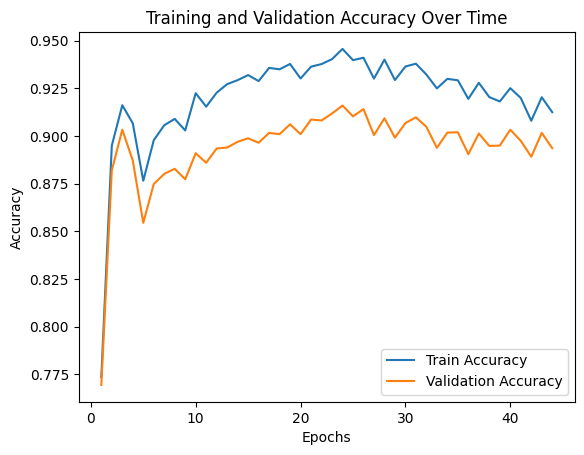

In [32]:
# Visualizing the accuracies
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()
plt.show()

In [33]:
print(f'Best Model Accuracy on Validation set is: {np.round(best_val_acc * 100)}%')

Best Model Accuracy on Validation set is: 92.0%


**1. Testing on Remaining Test Set:**
- It loops through images not used for validation.
- For each image:
    - Gets a prediction from the best model.
    - Extracts predicted and true labels.
    - Stores them as pairs for later analysis.

**2. Calculating Accuracy:**
- Counts correct predictions using list comprehension.
- Divides correct by total to get accuracy.

**3. Printing Results:**
- Outputs number of correct predictions, total predictions, and accuracy percentage.



In [34]:
# Iterating over the rest of the test images that we didnt include in val_set
all_preds = []
for image in range(len(test_labels), len(test_labels_all)):
    test_image = test_images_all[image]
    test_label = test_labels_all[image]
    predicted_label = model_prediction(best_model, test_image, bn_means, bn_vars)
    predicted_label = np.argmax(predicted_label)
    test_label = np.argmax(test_label)
    all_preds.append((predicted_label,test_label))

correct_predictions = sum(1 for pred, true_label in all_preds if pred == true_label)
accuracy = np.round(correct_predictions / len(all_preds) * 100, 2)

print(f'Correct predictions count is: {correct_predictions} out of {len(all_preds)}\nThe accuracy is: {accuracy}%')

Correct predictions count is: 3675 out of 4000
The accuracy is: 91.88%


In [35]:
# Predicting a random images
res = evaluate_accuracy_one_sample(best_model, test_images_all[6123], test_labels_all[6123], bn_means, bn_vars)
res 


True

## Draft cells


In [36]:
np.random.seed(42)
x = np.random.uniform(-3,3, size=(3,3))
x_corr = x/(1 - 0.9)
print(f'oringinal x:\n{x}')
print()
print(f'corrected x:\n{x_corr}')
print()
print(f'divide without correction x:\n{x/np.sqrt(25)}')
print()
print(f'divide with correction x:\n{x_corr/np.sqrt(25)}')


oringinal x:
[[-0.75275929  2.70428584  1.39196365]
 [ 0.59195091 -2.06388816 -2.06403288]
 [-2.65149833  2.19705687  0.60669007]]

corrected x:
[[ -7.52759287  27.04285838  13.91963651]
 [  5.91950905 -20.63888157 -20.64032878]
 [-26.51498327  21.97056875   6.0669007 ]]

divide without correction x:
[[-0.15055186  0.54085717  0.27839273]
 [ 0.11839018 -0.41277763 -0.41280658]
 [-0.53029967  0.43941137  0.12133801]]

divide with correction x:
[[-1.50551857  5.40857168  2.7839273 ]
 [ 1.18390181 -4.12777631 -4.12806576]
 [-5.30299665  4.39411375  1.21338014]]


In [37]:
# Simulating the error 
np.random.seed(42)
preds = model_prediction(model, test_images[0:16], bn_means, bn_vars) # 16x10
print(f'Actual Label of example 1:\n {test_labels[0:16][0]}')
print()
print(f'Prediction of the model of example 1:\n {preds[0]}')
print()
print(f'Subtraction of the predection and the actual label example 1:\n {(preds - test_labels[0:16])[0]}') # This is the pure error which is we are going to calculate the dervitive according to it
print('-------------------------')
print((test_labels[0:16]).shape)
print((preds.shape))

Actual Label of example 1:
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Prediction of the model of example 1:
 [0.00000000e+000 5.41669804e-225 6.99085337e-300 3.69931241e-249
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
 0.00000000e+000 4.28885549e-255]

Subtraction of the predection and the actual label example 1:
 [0.00000000e+000 5.41669804e-225 6.99085337e-300 3.69931241e-249
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.28885549e-255]
-------------------------
(16, 10)
(16, 10)


In [38]:
print(np.argmax(preds, axis=1))
print(np.argmax(test_labels[0:16], axis=1))
print(np.mean(np.argmax(preds, axis=1) == np.argmax(test_labels[0:16], axis=1)))
print(np.argmax(preds[0])) # taking a list and returning the index of the greatest number of this list

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 3]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
0.875
7


In [39]:
test = np.zeros((HIDDEN_LAYER_SIZE, 1))
test2 = test.reshape(1, -1)
test2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [40]:
np.random.seed(42)
weight = np.random.uniform(-0.5,0.5, size=(3,4))
out_delta = np.random.uniform(0,1, size=(1,3))
hidden_delta = out_delta.dot(weight)

print(hidden_delta)
print()
print(weight)
weight -= 0.01 * hidden_delta
print()
print(weight)

[[-0.15909362  0.33998078  0.01211581  0.24532239]]

[[-0.12545988  0.45071431  0.23199394  0.09865848]
 [-0.34398136 -0.34400548 -0.44191639  0.36617615]
 [ 0.10111501  0.20807258 -0.47941551  0.46990985]]

[[-0.12386894  0.4473145   0.23187278  0.09620526]
 [-0.34239042 -0.34740529 -0.44203755  0.36372292]
 [ 0.10270595  0.20467277 -0.47953666  0.46745663]]


In [41]:
np.random.seed(42)
sdw = np.random.uniform(-0.001,0.001, size=(4,4))
print(sdw)
print()
print(sdw + epsilon)

[[-0.00025092  0.00090143  0.00046399  0.00019732]
 [-0.00068796 -0.00068801 -0.00088383  0.00073235]
 [ 0.00020223  0.00041615 -0.00095883  0.00093982]
 [ 0.00066489 -0.00057532 -0.00063635 -0.00063319]]

[[-0.00025091  0.00090144  0.000464    0.00019733]
 [-0.00068795 -0.000688   -0.00088382  0.00073236]
 [ 0.00020224  0.00041616 -0.00095882  0.00093983]
 [ 0.0006649  -0.00057531 -0.00063634 -0.00063318]]


In [42]:
x = np.random.randint(0,5,size=(128,10))
b = np.random.randint(2,3, size=(1,10))
print((b - x).shape)
print((b - np.mean(x)).shape)

(128, 10)
(1, 10)
